In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [3]:
p_name = "Object_recognition_basics"

# Data setup

In [4]:
PATH = Path('data/pascal')
assert str(PATH) == 'data/pascal'
list(PATH.iterdir())

[PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/models'),
 PosixPath('data/pascal/tmp')]

### Annotations for the bound boxes

In [5]:
trn_json = json.load((PATH / 'pascal_train2007.json').open())
assert trn_json.keys() is not []
trn_json.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

###### Better to use CONSTANTS as provide better auto-complete and we don't mistype them

In [6]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']

In [7]:
trn_json[IMAGES][:2]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480}]

In [8]:
trn_json[ANNOTATIONS][:1]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]}]

In [9]:
trn_json[CATEGORIES][:2]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'}]

### Let's create some dict of key data

In [10]:
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name','id','image_id','category_id','bbox'

In [11]:
cats = {cat[ID] : cat['name'] for cat in trn_json[CATEGORIES]}

In [12]:
cats

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [13]:
trn_fnames = {img[ID] : img[FILE_NAME] for img in trn_json[IMAGES]}

In [14]:
trn_ids = [img[ID] for img in trn_json[IMAGES]]

In [15]:
trn_ids[:2]

[12, 17]

In [16]:
' '.join(trn_fnames[key] for key in trn_ids[:5])

'000012.jpg 000017.jpg 000023.jpg 000026.jpg 000032.jpg'

In [17]:
JPEGS_PATH = 'VOCdevkit/VOC2007/JPEGImages'

In [18]:
IMG_PATH = PATH / JPEGS_PATH
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/006948.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005796.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007006.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/004693.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/002279.jpg')]

In [19]:
img0_d = trn_json[IMAGES][0]
img0_d[FILE_NAME], img0_d[ID]

('000012.jpg', 12)

A `defaultdict` is useful any time you want to have a default dictionary entry for new keys. Here we create a dict from image IDs to a list of annotations (tuple of bounding box and class id).

#### We convert VOC's height/width into top-left/bottom-right, and switch x/y coords to be consistent with numpy.

In [20]:
trn_json[ANNOTATIONS][0]

{'area': 34104,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0,
 'image_id': 12,
 'iscrowd': 0,
 'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]}

In [21]:
trn_anno = collections.defaultdict(lambda: []) # empty dict
for a in trn_json[ANNOTATIONS]:
    if not a['ignore']:
        bb = a[BBOX]
        bb = np.array([bb[1], bb[0], bb[3] + bb[1] - 1, bb[2] + bb[0] - 1])
        trn_anno[a[IMG_ID]].append( (bb, a[CAT_ID]) )

In [22]:
trn_anno[img0_d[ID]]

[(array([ 96, 155, 269, 350]), 7)]

In [23]:
cats[7]

'car'

In [24]:
def bb_2_hw(hw):
    """
    Some libs take VOC format bounding boxes, so this let's us convert back when required:
    """
    return np.array([hw[1], hw[0], hw[3] - hw[1], hw[2] - hw[0]])
    

In [25]:
def show_img(img, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
        
    ax.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    return ax

In [26]:
def draw_outline(shape, line_w):
    shape.set_path_effects( [patheffects.Stroke(linewidth=line_w, 
                                              foreground='black'), patheffects.Normal()] )

###### Note that `*` in argument lists is the [splat operator](https://stackoverflow.com/questions/5239856/foggy-on-asterisk-in-python). In this case it's a little shortcut compared to writing out `b[-2],b[-1]`.

In [27]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [28]:
def draw_txt(ax, pos, txt, sz=14):
    text = ax.text(*pos, txt, verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [29]:
img0_d[ID]

12

In [30]:
a_img = trn_anno[img0_d[ID]][0]; a_img

(array([ 96, 155, 269, 350]), 7)

In [31]:
im = open_image(IMG_PATH / img0_d[FILE_NAME])

[ 96 155 269 350]
[155  96 195 173]
7
car


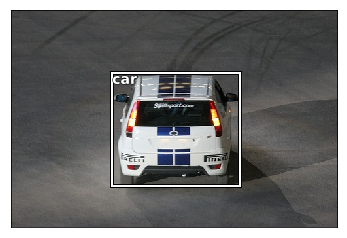

In [32]:
ax = show_img(im)
b = bb_2_hw(a_img[0])
print(a_img[0])
print(b)
print(a_img[1])
print(cats[a_img[1]])
draw_rect(ax, b)
draw_txt(ax, b[:2], cats[a_img[1]])

In [33]:
def draw_im(img, anno):
    ax = show_img(img, figsize=(16, 8))
    for box, cat_id in anno: # render all bounding boxes
        b = bb_2_hw(box)
        draw_rect(ax, b)
        draw_txt(ax, b[:2], cats[cat_id], sz=16 )

In [34]:
def draw_anno_idx(a_idx):
    img_anno = trn_anno[a_idx]
    img = open_image(IMG_PATH / trn_fnames[a_idx])
    print(img.shape)
    draw_im(img, img_anno)

(364, 480, 3)


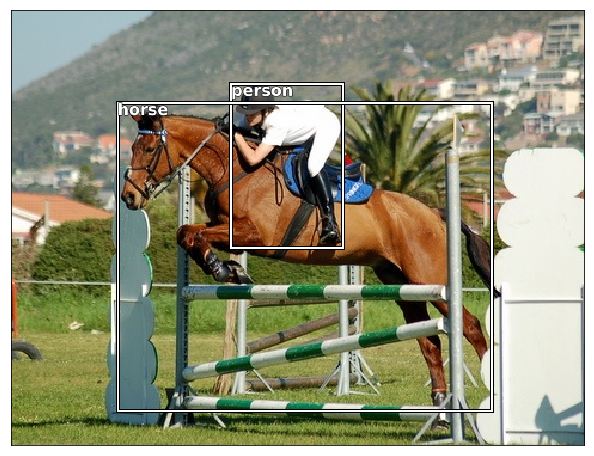

In [35]:
draw_anno_idx(17)

#### Get the larget bounding box for each annotation

In [36]:
trn_anno[23]

[(array([229,   8, 499, 244]), 2),
 (array([219, 229, 499, 333]), 2),
 (array([  0,   1, 368, 116]), 15),
 (array([  1,   2, 461, 242]), 15),
 (array([  0, 224, 485, 333]), 15)]

In [37]:
def get_lrg(b):
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [38]:
trn_lrg_anno = {id: get_lrg(bb) for id, bb in trn_anno.items()}
bb, cat = trn_lrg_anno[23]
bb = bb_2_hw(bb)

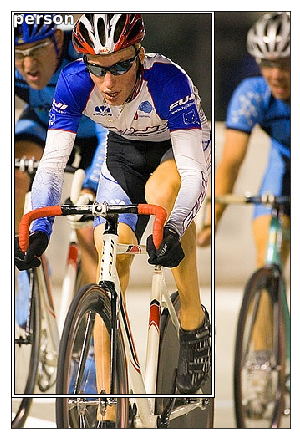

In [39]:
ax = show_img(open_image(IMG_PATH / trn_fnames[23]), figsize=(5, 10))
draw_rect(ax, bb)
draw_txt(ax, bb[:2], cats[cat], sz=16)

#### Often it's easiest to simply create a CSV of the data you want to model, rather than trying to create a custom dataset. Here we use Pandas to help us create a CSV of the image filename and class.

In [40]:
(PATH / 'tmp').mkdir(exist_ok=True)

In [41]:
lrg_bb_csv = PATH / 'tmp/largest_bb.csv'

In [42]:
df = pd.DataFrame({'fn': [trn_fnames[i] for i in trn_ids], 
                'cat' : [cats[trn_lrg_anno[i][1]] for i in trn_ids]}, 
               columns=['fn', 'cat'] )

In [43]:
df.head()

,fn,cat
0,000012.jpg,car
1,000017.jpg,horse
2,000023.jpg,person
3,000026.jpg,car
4,000032.jpg,aeroplane


In [44]:
df.to_csv(lrg_bb_csv, index=False)

# Model - similar to cats Vs dogs

In [45]:
f_model = resnet34
sz = 224
bs = 64

In [46]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
model_data = ImageClassifierData.from_csv(PATH, JPEGS_PATH, lrg_bb_csv, tfms=tfms)

In [47]:
x, y = next(iter(model_data.trn_dl))

In [48]:
x.shape

torch.Size([64, 3, 224, 224])

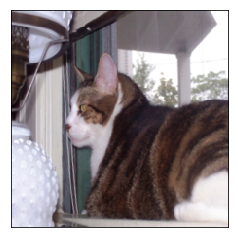

In [49]:
show_img(model_data.val_ds.denorm(to_np(x))[0])

In [50]:
learn = ConvLearner.pretrained(f_model, model_data, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [51]:
lr_f = learn.lr_find(1e-5, 100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 25/32 [00:09<00:02,  2.51it/s, loss=10.4]


#### When you LR finder graph looks like this, you can ask for more points on each end:

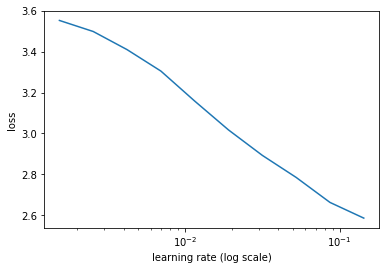

In [52]:
learn.sched.plot()

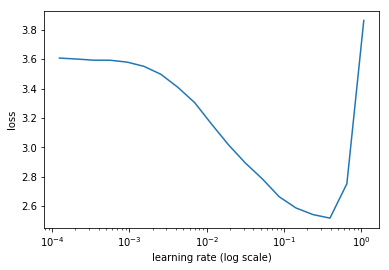

In [53]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [54]:
lr = 1e-1

In [55]:
learn.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      2.667941   1.341929   0.77494   



[1.3419294, 0.7749399021267891]

In [56]:
lrs = np.array([lr/1000, lr/100, lr])

In [57]:
learn

Sequential(
  (0): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-

In [58]:
learn.freeze_to(-2) # unfreeze last 2 layers

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 27/32 [00:18<00:03,  1.43it/s, loss=30.2]

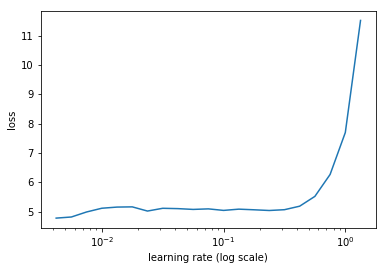

In [59]:
lr_f = learn.lr_find(lr/100)
learn.sched.plot(n_skip=5, n_skip_end=1)

In [60]:
learn.fit(lrs/10, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

  3%|▎         | 1/32 [00:01<00:48,  1.55s/it, loss=1.81]

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.730993   0.937816   0.813852  
    1      1.163243   0.734705   0.835337                 



[0.73470485, 0.8353365361690521]

In [61]:
learn.unfreeze()

In [62]:
learn.fit(lrs / 15, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.23162    0.897331   0.776292  
    1      0.800876   0.798042   0.792819                  



[0.7980421, 0.792818509042263]

In [63]:
learn.save('class_one')
learn.load('class_one')

#### Accuracy isn't improving much - `since many images have multiple different objects`, it's going to be impossible to be that accurate.

## Let's check the results

In [64]:
x, y = next(iter(model_data.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x, preds = to_np(x), to_np(probs)
preds = np.argmax(preds, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


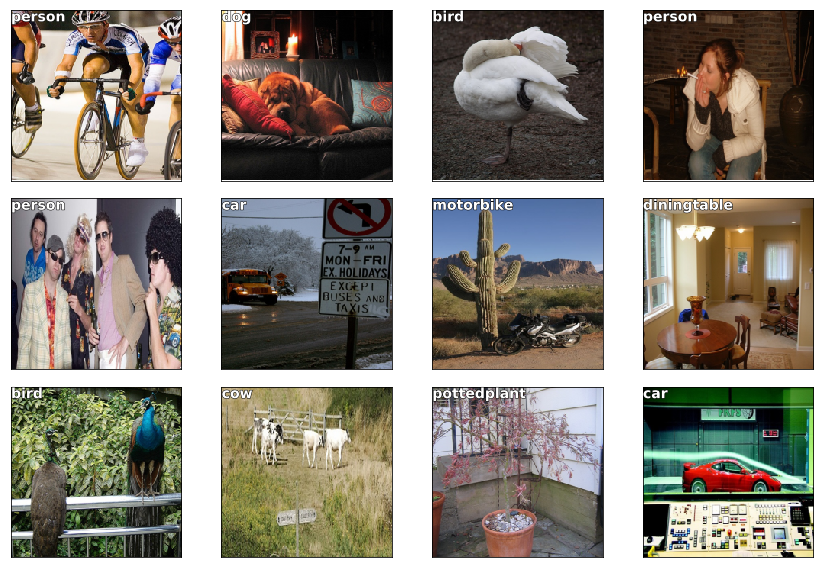

In [65]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ima = model_data.val_ds.denorm(x)[i]
    b =   model_data.classes[preds[i]]
    ax =  show_img(ima, ax=ax)
    draw_txt(ax, (0,0), b)
plt.tight_layout()

## Bounded box

In [66]:
BB_CSV = PATH/'tmp/bb.csv'

###### Now we'll try to find the bounding box of the largest object. This is simply a regression with 4 outputs. So we can use a CSV with multiple 'labels'.

In [85]:
trn_lrg_anno[23]

(array([  1,   2, 461, 242]), 15)

In [86]:
bb = np.array([trn_lrg_anno[id][0] for id in trn_ids])
bb_s = [' '.join(str(cord) for cord in cords) for cords in bb]

print(bb[0])
print(bb_s[0])

[ 96 155 269 350]
96 155 269 350


In [88]:
df = pd.DataFrame({'fn' : [trn_fnames[id] for id in trn_ids], 'bbox' : bb_s}, columns=['fn', 'bbox'])

In [89]:
df.head()

,fn,bbox
0,000012.jpg,96 155 269 350
1,000017.jpg,77 89 335 402
2,000023.jpg,1 2 461 242
3,000026.jpg,124 89 211 336
4,000032.jpg,77 103 182 374


In [90]:
df.to_csv(BB_CSV, index=False)

In [91]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

## Train

In [92]:
f_model = resnet34
sz = 224
bs = 64

Set `continuous=True` to tell fastai this is a **regression problem**, which means it **won't one-hot encode the labels**, and will use **MSE** as the default crit.

**Note** that we have to tell the transforms **constructor that our labels are coordinates**, so that it can handle the transforms correctly.

Also, we use **CropType.NO** because we want to 'squish' the rectangular images into squares, rather than center cropping, so that we don't accidentally crop out some of the objects. (This is less of an issue in something like imagenet, where there is a single object to classify, and it's generally large and centrally located).

In [93]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
model_data = ImageClassifierData.from_csv(PATH, JPEGS_PATH, BB_CSV, tfms=tfms, continuous=True)

In [94]:
x, y = next(iter(model_data.val_dl))

In [97]:
img = model_data.val_ds.denorm(to_np(x))[0]
b = bb_2_hw(to_np(y[0])); b

array([ 49.,   0., 131., 205.], dtype=float32)

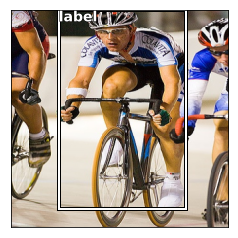

In [98]:
ax = show_img(img)
draw_rect(ax, b)
draw_txt(ax, b[:2], 'label')

### Custom layer

fastai let's you use a `custom_head` to add **your own module on top of a convnet**, _instead of the adaptive pooling and fully connected net which is added by default_. In this case, we **don't want to do any pooling, since we need to know the activations of each grid cell.**

The _final layer has 4 activations, one per bounding box coordinate._ Our **target is continuous**, not categorical, so the **MSE loss function used does not do any sigmoid or softmax** to the module outputs.

In [103]:
last_layer = nn.Sequential(Flatten(), nn.Linear(25088, 4))
learn = ConvLearner.pretrained(f_model, model_data, custom_head=last_layer)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [104]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 81%|████████▏ | 26/32 [00:07<00:01,  3.47it/s, loss=481] 


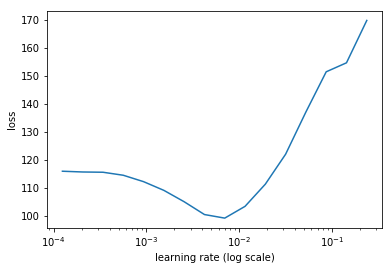

In [116]:
lrf = learn.lr_find(1e-5, 100)
learn.sched.plot(5)

In [117]:
lr = 2e-3

In [ ]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

In [ ]:
lrs = np,array([lr / 100, lr / 10, lr])

In [ ]:
learn.freeze_to(-2)

In [ ]:
lrf = learn.lr_find(lrs / 1000)
learn.sched.plot(1)

In [ ]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

In [ ]:
learn.freeze_to(-3)

In [ ]:
learn.fit(lrs, 1, cycle_len=2)

In [ ]:
learn.save('bb_4cords')

In [ ]:
learn.load('bb_4cords')